In [15]:
import glob
import gzip
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pysam
from pyBioInfo.Range import GRange
from pyBioInfo.IO.File import BamFile, GtfFile, GtfGeneBuilder
from pyBioInfo.Utils import ShiftLoader, BlockTools

# Fusion genes on ENCODE annotation

In [3]:
gtf = "/home/chenzonggui/species/homo_sapiens/GRCh38.p13/gencode.v39.annotation.sorted.gtf.gz"
with GtfFile(gtf) as f:
    all_genes = list(GtfGeneBuilder(f))
print("All genes:", len(all_genes))

All genes: 61533


In [4]:
genes = []
for g in all_genes:
    if g.chrom == "chrM":
        continue
    gtype = g.records["gene"][0].attributes["gene_type"]
    if gtype != "protein_coding": # and gtype != "lncRNA":
        continue
    genes.append(g)
genes.sort()
print("Protein coding genes:", len(genes))

Protein coding genes: 19969


In [5]:
genes1 = []
for g in genes:
    gname = g.records["gene"][0].attributes["gene_name"]
    if gname.startswith("ENSG"):
        genes1.append(g)
print("Genes:", len(genes1))

Genes: 594


# Summary of overlap genes

In [2]:
gtf = "/home/chenzonggui/species/homo_sapiens/GRCh38.p13/gencode.v39.annotation.sorted.gtf.gz"
with GtfFile(gtf) as f:
    all_genes = list(GtfGeneBuilder(f))
print("All genes:", len(all_genes))

All genes: 61533


In [7]:
# filter genes

genes = []
for g in all_genes:
    if g.chrom == "chrM":
        continue
    gtype = g.records["gene"][0].attributes["gene_type"]
    if gtype != "protein_coding": # and gtype != "lncRNA":
        continue
    genes.append(g)
genes.sort()
print("Protein coding genes:", len(genes))

Protein coding genes: 19969


In [8]:
tmp = []
for g in genes:
    gname = g.records["gene"][0].attributes["gene_name"]
    g.gname = gname
    if not gname.startswith("ENSG"):
        tmp.append(g)
genes = tmp
print("Genes:", len(genes))

Genes: 19375


In [9]:
loader = ShiftLoader(genes)
for g1 in genes:
    overlap_genes = []
    for g2 in loader.fetch(obj=g1):
        if g2 is g1:
            continue
        overlap_genes.append(g2)
    g1.overlap_genes = overlap_genes

In [10]:
counter = Counter([len(g.overlap_genes) for g in genes])
for k, v in sorted(counter.items()):
    print(k, v, sep="\t")

0	13919
1	4434
2	814
3	133
4	13
5	5
6	3
8	9
9	2
10	3
11	1
13	1
14	15
16	1
21	22


[13919  4434   814   133    13     5     3     0     9]


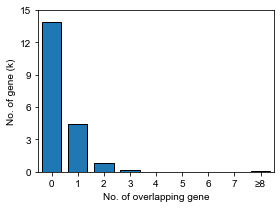

In [11]:
xs = np.arange(9)
ys = np.array([counter[x] for x in xs])
print(ys)

ys[-1] = sum(counter.values()) - sum(ys[:-1])
ys = ys / 1000
ticks = [str(x) for x in xs]
ticks[-1] = "≥%s" % ticks[-1]

plt.figure(figsize=(4, 3))
plt.bar(xs, ys, edgecolor="black", width=0.75)
plt.xlim(min(xs) - 0.5, max(xs) + 0.5)
plt.ylim(0, 15)
plt.xlabel("No. of overlapping gene")
plt.ylabel("No. of gene (k)")
plt.xticks(xs, ticks)
plt.yticks([0, 3, 6, 9, 12, 15])
plt.tight_layout()
plt.savefig("figures/summary_of_overlap_genes.pdf", dpi=300)

806	3628


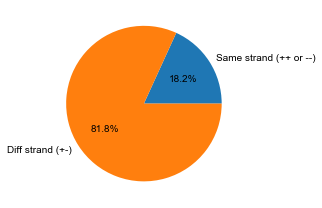

In [12]:
n1 = 0
n2 = 0
for g in genes:
    if len(g.overlap_genes) == 1:
        g1 = g.overlap_genes[0]
        if g.strand == g1.strand:
            n1 += 1
        else:
            n2 += 1
print(n1, n2, sep="\t")

plt.figure(figsize=(4, 3))
plt.pie([n1, n2], labels=["Same strand (++ or --)", "Diff strand (+-)"], autopct='%1.1f%%')
plt.tight_layout()
plt.savefig("figures/gene_pair_strands.pdf", dpi=300)

In [74]:
path = "../../1_NanoNASCseq/results/expression/report/gene_based/K562.all_cells.min_read_2_min_tc_2.annotated.tsv"
gene_expr = pd.read_csv(path, sep="\t", index_col=0)
gene_tpms = {gid: tpm for gid, tpm in zip(gene_expr.index, gene_expr["TPM"])}

In [75]:
path = "../../1_NanoNASCseq/results/expression/report/isoform_based/K562.treatment_cells.min_read_2_min_tc_2.annotated.tsv"
isoform_expr = pd.read_csv(path, sep="\t", index_col=0)
isoform_tpms = {tid: tpm for tid, tpm in zip(isoform_expr.index, isoform_expr["TPM"])}
isoform_ntrs = {tid: v for tid, v in zip(isoform_expr.index, isoform_expr["NTR"])}

6012	166	1327	42


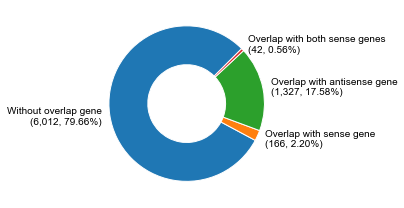

In [125]:
min_tpm = 10
genes1 = [] # without overlap
genes2 = [] # sense
genes3 = [] # antisense
genes4 = [] # sense + antisense
for g in genes:
    if gene_tpms.get(g.name, 0) < min_tpm:
        continue
    n1, n2 = 0, 0
    for g1 in g.overlap_genes:
        if gene_tpms.get(g1.name, 0) < min_tpm:
            continue
        if g1.strand == g.strand:
            n1 += 1
        else:
            n2 += 1
    if n1 == 0:
        if n2 == 0:
            genes1.append(g)
        else:
            genes3.append(g)
    else:
        if n2 == 0:
            genes2.append(g)
        else:
            genes4.append(g)
print(len(genes1), len(genes2), len(genes3), len(genes4), sep="\t")
vs = [len(genes1), len(genes2), len(genes3), len(genes4)]
labels = [
    "Without overlap gene\n(%s, %.2f%%)" % (format(vs[0], ","), vs[0]*100/sum(vs)),
    "Overlap with sense gene\n(%s, %.2f%%)" % (format(vs[1], ","), vs[1]*100/sum(vs)),
    "Overlap with antisense gene\n(%s, %.2f%%)" % (format(vs[2], ","), vs[2]*100/sum(vs)),
    "Overlap with both sense genes\n(%s, %.2f%%)" % (format(vs[3], ","), vs[3]*100/sum(vs))]
plt.figure(figsize=(5.5, 3))
plt.pie(vs, colors=["C0", "C1", "C2", "C3"], radius=1, startangle=45,
        # autopct='%1.1f%%', pctdistance=0.8,
        wedgeprops=dict(width=0.5, edgecolor='w'), labels=labels)
plt.tight_layout()
plt.savefig("figures/summary_of_overlap_genes.pie.pdf", dpi=300)

In [129]:
min_tpm = 50
for g1 in genes3:
    # print("=" * 80)
    # print(g1.name)
    for g2 in g1.overlap_genes:
        for t1 in g1.transcripts:
            tpm1 = isoform_tpms.get(t1.name, 0)
            if tpm1 < min_tpm:
                continue
            ntr1 = isoform_ntrs[t1.name]
            for t2 in g2.transcripts:
                if min(t1.end, t2.end) < max(t1.start, t2.start):
                    continue
                tpm2 = isoform_tpms.get(t2.name, 0)
                if tpm2 < min_tpm:
                    continue
                ntr2 = isoform_ntrs[t2.name]
                if ntr1 - ntr2 < 0.3:
                    continue
                print("-" * 80)
                print(t1.format())
                print(t2.format())
                print("TPM1:", tpm1)
                print("TPM2:", tpm2)
                print("NTR1:", ntr1)
                print("NTR2:", ntr2)
                print("NTR1 - NTR2:", ntr1 - ntr2)
                # print(isoform_expr.loc[[t1.name, t2.name]])

--------------------------------------------------------------------------------
chr1	37802944	37808208	ENST00000373044.3	.	-	37803927	37808180	255,0,0	5	1053,143,120,115,417,	0,1357,3912,4156,4847,
chr1	37807746	37809449	ENST00000468084.1	.	+	37808684	37809070	0,0,255	3	560,202,472,	0,784,1231,
TPM1: 89.133535079481
TPM2: 71.74162579567985
NTR1: 0.8048780487804879
NTR2: 0.21212121212121213
NTR1 - NTR2: 0.5927568366592757
--------------------------------------------------------------------------------
chr11	62789970	62792006	ENST00000307366.8	.	-	62790625	62791994	255,0,0	2	945,328,	0,1708,
chr11	62787401	62790400	ENST00000333449.9	.	+	62787431	62790044	0,0,255	5	126,188,135,79,515,	0,1621,1890,2199,2484,
TPM1: 60.87168249330411
TPM2: 156.52718355421058
NTR1: 0.6071428571428571
NTR2: 0.06944444444444445
NTR1 - NTR2: 0.5376984126984127
--------------------------------------------------------------------------------
chr12	120446443	120463749	ENST00000551765.6	.	+	120446480	120459956	0,0,

In [131]:
tmp = isoform_expr.loc[["ENST00000373044.3", "ENST00000468084.1", "ENST00000234170.10", "ENST00000402297.6"]]
tmp.to_csv("results/case_isoforms.tsv", sep="\t")